In [20]:
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pickle
from statistics import mean, stdev
import seaborn as sns

In [ ]:
#Directory variables

VPREC_IB_DIR = 'vprec_ib'
VPREC_OB_DIR = 'vprec_ob'
IEEE_DIR = '/home/ines/Documents/Thesis/Verrou_corrected'
IEEE_PROTEIN_SCORE_REF = 'ieee_ref.pkl'
THRESHOLD = 0.3

## Calculate protein stats

### VPREC OB

In [27]:
docker_pred = {}
for f1 in [23,7]:
    for f2 in [23,10,7,2]:
        
        docker_pred['%s_%s'%(f1,f2)] = {}
        
        if f1==23 and f2==2: continue
        if f1==7 and f2==2: continue
                
        for i in range(0,646):

            f = open(VPREC_OB_DIR + '/%s_%s_%s.pkl'%(f1,f2,i), 'rb')
            temp = pickle.load(f)
               
            pkl_dict = {}
            for prot in temp:
                pkl_dict[prot] = {}
                for go_id in temp[prot]:
                    if temp[prot][go_id] >= 0.3:
                        pkl_dict[prot][go_id] = np.float64(temp[prot][go_id])

            for protein in pkl_dict.keys():

                docker_pred['%s_%s'%(f1,f2)][protein] = {}
                for go_id in pkl_dict[protein]:
                    docker_pred['%s_%s'%(f1,f2)][protein][go_id] = np.array([pkl_dict[protein][go_id]])

                    
original_file = open(IEEE_DIR + IEEE_PROTEIN_SCORE_REF, 'rb')
pkl_dict = pickle.load(original_file)
original_results = {}

for protein in pkl_dict:
    original_results[protein] = pkl_dict[protein]

### VPREC IB

In [5]:
docker_pred = {}
for f1 in [23,7, 2]:
    for f2 in [23,10,7,2]:
        
        docker_pred['%s_%s'%(f1,f2)] = {}
        
        if f1==23 and f2==2: continue
        if f1==7 and f2==2: continue
        if f1==2 and f2==2: continue
                
        for i in range(0,646):

            f = open(VPREC_IB_DIR + '/%s_%s_%s.pkl'%(f1,f2,i), 'rb')
            temp = pickle.load(f)
               
            pkl_dict = {}
            for prot in temp:
                pkl_dict[prot] = {}
                for go_id in temp[prot]:
                    if temp[prot][go_id] >= 0.3:
                        pkl_dict[prot][go_id] = np.float64(temp[prot][go_id])

            for protein in pkl_dict.keys():

                docker_pred['%s_%s'%(f1,f2)][protein] = {}
                for go_id in pkl_dict[protein]:
                    docker_pred['%s_%s'%(f1,f2)][protein][go_id] = np.array([pkl_dict[protein][go_id]])

                    
original_file = open(IEEE_DIR + IEEE_PROTEIN_SCORE_REF, 'rb')
pkl_dict = pickle.load(original_file)
original_results = {}

for protein in pkl_dict:
    original_results[protein] = pkl_dict[protein]

In [28]:
missing = {}
same = {}
new = {}

for f1 in [23,7]:
    for f2 in [23,10,7,2]:
        missing['%s_%s'%(f1,f2)] = {}
        same['%s_%s'%(f1,f2)] = {}
        new['%s_%s'%(f1,f2)] = {}
        for prot in docker_pred['%s_%s'%(f1,f2)]:
            
            missing['%s_%s'%(f1,f2)][prot] = []
            same['%s_%s'%(f1,f2)][prot] = []
            new['%s_%s'%(f1,f2)][prot] = []
            
            for go_id in docker_pred['%s_%s'%(f1,f2)][prot]:
                
                if go_id not in original_results[prot].keys(): new['%s_%s'%(f1,f2)][prot].append(go_id)
                else: same['%s_%s'%(f1,f2)][prot].append(go_id)
                    
            for go_id in original_results[prot]:
                if go_id not in docker_pred['%s_%s'%(f1,f2)][prot].keys(): missing['%s_%s'%(f1,f2)][prot].append(go_id)


missing_count = {}
new_count = {}
same_count = {}

for f1 in [23,7]:
    for f2 in [23,10,7,2]:
        missing_count['%s_%s'%(f1,f2)] = 0
        same_count['%s_%s'%(f1,f2)] = 0
        new_count['%s_%s'%(f1,f2)] = 0
        
        for prot in missing['%s_%s'%(f1,f2)]:
            missing_count['%s_%s'%(f1,f2)] += len(missing['%s_%s'%(f1,f2)][prot])
            new_count['%s_%s'%(f1,f2)] += len(new['%s_%s'%(f1,f2)][prot])
            same_count['%s_%s'%(f1,f2)] += len(same['%s_%s'%(f1,f2)][prot])

del same_count['23_2']
del missing_count['23_2']
del new_count['23_2']
del same_count['7_2']
del missing_count['7_2']
del new_count['7_2']

### Metrics

In [37]:
#to avoid duplicate cells point METRICS_DIR to vprec_ob or vprec_ib results
METRICS_DIR = VPREC_OB_DIR

In [30]:
#metric stats
metrics = {}
metric_stats = {}
df_metric = {}

for category in ['bp', 'cc', 'mf']:

    df_metric[category] = {}
    metrics[category] = {}
    metric_stats[category] = {}
        
    for f1 in [23,7,2]:
        for f2 in [23,10,7]:
            if f1 == 2: continue #uncomment for VPREC OB
            
            df_metric[category]['%s_%s'%(f1,f2)] = {}
            metrics[category]['%s_%s'%(f1,f2)] = {'threshold':[], 'Smin':[], 'Fmax':[], 'AUPR':[]}
            metric_stats[category]['%s_%s'%(f1,f2)] = {'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}

            metrics_file = open(METRICS_DIR + "/%s_%s_%s.txt"%(category,f1,f2)) #verrou_formats4
            read_file = csv.reader(metrics_file)

            next(read_file)
            for row in read_file: 
#                 if 'Smin threshold' in row[0] or 'Precision' in row[0] or 'Recall' in row[0] or 'Positive' in row[0] or 'Negative' in row[0] : continue
                metric, score = row[0].split(': ')
                metrics[category]['%s_%s'%(f1,f2)][metric].append(np.float64(score))

            metrics_file = csv.reader(open(IEEE_DIR + "/%s.txt"%category))
            next(metrics_file)
            for row in metrics_file:
#                 if 'Smin threshold' in row[0] or 'Precision' in row[0] or 'Recall' in row[0] or 'Positive' in row[0] or 'Negative' in row[0] : continue
                term, score = row[0].split(': ')
                metric_stats[category]['%s_%s'%(f1,f2)][term]['Original Result'] = [np.float64(score)]

            for i in metrics[category]['%s_%s'%(f1,f2)]: 
                    
                metric_stats[category]['%s_%s'%(f1,f2)][i]['VPREC Results'] = metrics[category]['%s_%s'%(f1,f2)][i]
                df_metric[category]['%s_%s'%(f1,f2)]['%s'%i] = pd.DataFrame(metric_stats[category]['%s_%s'%(f1,f2)][i])

# Graphics

### VPREC OB

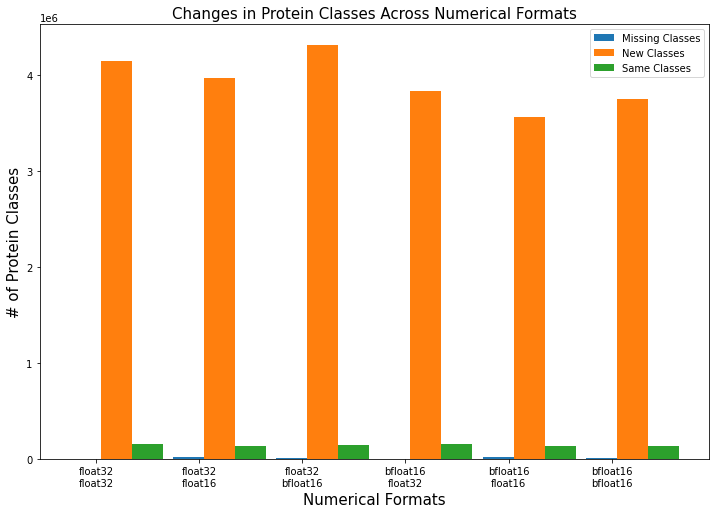

In [31]:
bar_width = 0.3
fig, ax = plt.subplots(figsize=(12, 8))
b1 = ax.bar(np.arange(6), list(missing_count.values()), width=bar_width, label='Missing Classes')
b2 = ax.bar(np.arange(6) + bar_width, list(new_count.values()), width=bar_width, label='New Classes')
b3 = ax.bar(np.arange(6) + 2*bar_width, list(same_count.values()), width=bar_width, label='Same Classes')
ax.set_xticks(np.arange(6) + bar_width/3), ax.legend(), ax.set_title('Changes in Protein Classes Across Numerical Formats', fontsize=15)
ax.set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16']);
ax.set_xlabel('Numerical Formats', fontsize=15), ax.set_ylabel('# of Protein Classes', fontsize=15);

### VPREC IB

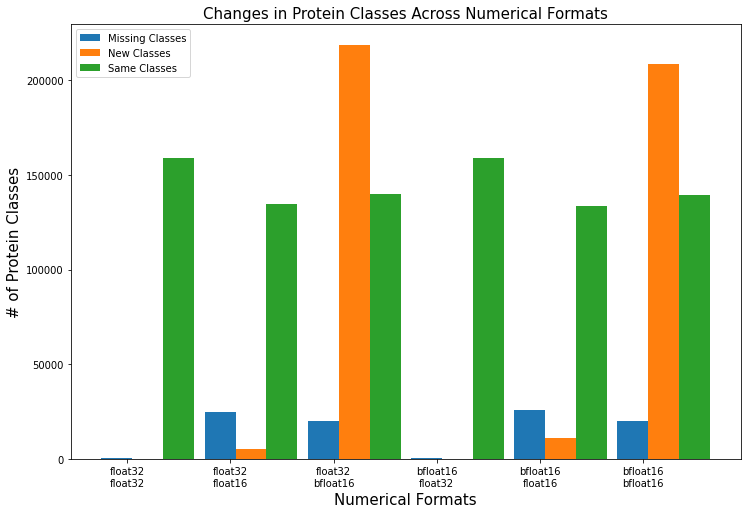

In [8]:
bar_width = 0.3
fig, ax = plt.subplots(figsize=(12, 8))
b1 = ax.bar(np.arange(6), list(missing_count.values()), width=bar_width, label='Missing Classes')
b2 = ax.bar(np.arange(6) + bar_width, list(new_count.values()), width=bar_width, label='New Classes')
b3 = ax.bar(np.arange(6) + 2*bar_width, list(same_count.values()), width=bar_width, label='Same Classes')
ax.set_xticks(np.arange(6) + bar_width/3), ax.legend(), ax.set_title('Changes in Protein Classes Across Numerical Formats', fontsize=15)
ax.set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16']);
ax.set_xlabel('Numerical Formats', fontsize=15), ax.set_ylabel('# of Protein Classes', fontsize=15);

## Metrics

-34.31470215659345 6.9926014187602314


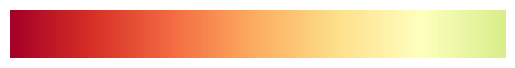

In [30]:
def normalize(x,a,b): #normalization map: [a,b] --> [0,1]
    if a>b:
        raise ValueError('(a,b) is not an interval')
    return (float(x)-a)/(b-a)

def asymmetric_cmap(data, div_cmap, ref_point=0.0, name= 'asym_cmap'):
    '''
    Input
    -----
      data: data to be visualized (a numpy aray of shape (m,n), a data frame, a list of lists of equal len)
      div_cmap :  a diverging matplotlib or seaborn colormap  (a matplotlib.colors.LinearSegmentedColormap object)
      ref_point is the reference point for data, the threshold of interest  
    '''
    if isinstance(data, pd.DataFrame):
        D = data.values
    elif isinstance(data, np.ma.core.MaskedArray):
        D=np.ma.copy(data)
    else:    
        D=np.asarray(data, dtype=float) 
    D=np.ma.masked_invalid(D)
#     print(D)
    
    dmin=np.min(D)
    dmax=np.max(D)
    print(dmin, dmax)
    
    if not (dmin < ref_point < dmax):
        raise ValueError('data are not appropriate for visualization with a diverging colormap')
        
    if dmax-ref_point > ref_point-dmin:
        left=2*ref_point-dmax
        right=dmax
        
        tp=normalize(dmin, left,right)#normalized value of dmin
        refp_norm=normalize(ref_point, left, right) # normalized value of the ref_point in the symmetric interval
                                                   #[left, right]. It is 0.5 
       
        A=tp
        B=1.0
    else:
        left=dmin
        right=2*ref_point-dmin
        
        tp=normalize(dmax, left, right)#normalized value of dmax
        refp_norm=normalize(ref_point, left, right)
        
        A=0.0
        B=tp
    max_lumin_idx=normalize(refp_norm, A, B) # index for the max luminance position in the asymm div cmap
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # T is a (256,)  array 
    T = np.hstack([
        np.linspace(A, refp_norm, 128, endpoint=False), 
        np.linspace(refp_norm, B, 128)
    ])
   
    # T_assym is (256,) array 
    T_asymm = np.hstack([
        np.linspace(0, max_lumin_idx, 128, endpoint=False), 
        np.linspace(max_lumin_idx, 1.0, 128)
    ])

    for t, s in zip(T, T_asymm):
#         print(t)
        r, g, b, a = div_cmap(t)
#         print(r,g,b,a)

        cdict['red'].append((s, r, r))
        cdict['green'].append((s, g, g))
        cdict['blue'].append((s, b, b))
        cdict['alpha'].append((s, a, a))

    asym_cmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    # plt.register_cmap(cmap=asym_cmap)
    display_cmap(asym_cmap)
    return D, asym_cmap, dmin, dmax

def rand_lower_correl(n, a, b, dtype=float):
    if b<a:
        raise ValueError('b must be greater than a')
    nr=  n * (n + 1) / 2 - n
    A = np.zeros([n, n], dtype=dtype)
    A[np.tril_indices(n, -1)] = a+(b-a)*np.random.random(int(nr))
    return A

def display_cmap(cmap):
    plt.imshow(np.linspace(0, 100, 256)[None, :],  aspect=25, interpolation='nearest', cmap=cmap) 
    plt.axis('off')

# mask = np.zeros_like(C, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# C=rand_lower_correl(25, -0.4, 0.9)
# C = np.ma.array(C, mask=mask)  #mask out the upper triangle in C

cmap1=matplotlib.colormaps['RdYlGn']
cbar = []
for ont in ['cc', 'mf', 'bp']:
    for m in ['smin', 'fmax', 'aupr']:
#         print(heatmap[ont][m]['value'])
        cbar.append(list(heatmap[ont][m]['value']))
        
cbar = np.array(cbar)

plot_data, asym_cmap=asymmetric_cmap(cbar, cmap1, ref_point=0)[:2]


### VPREC OB

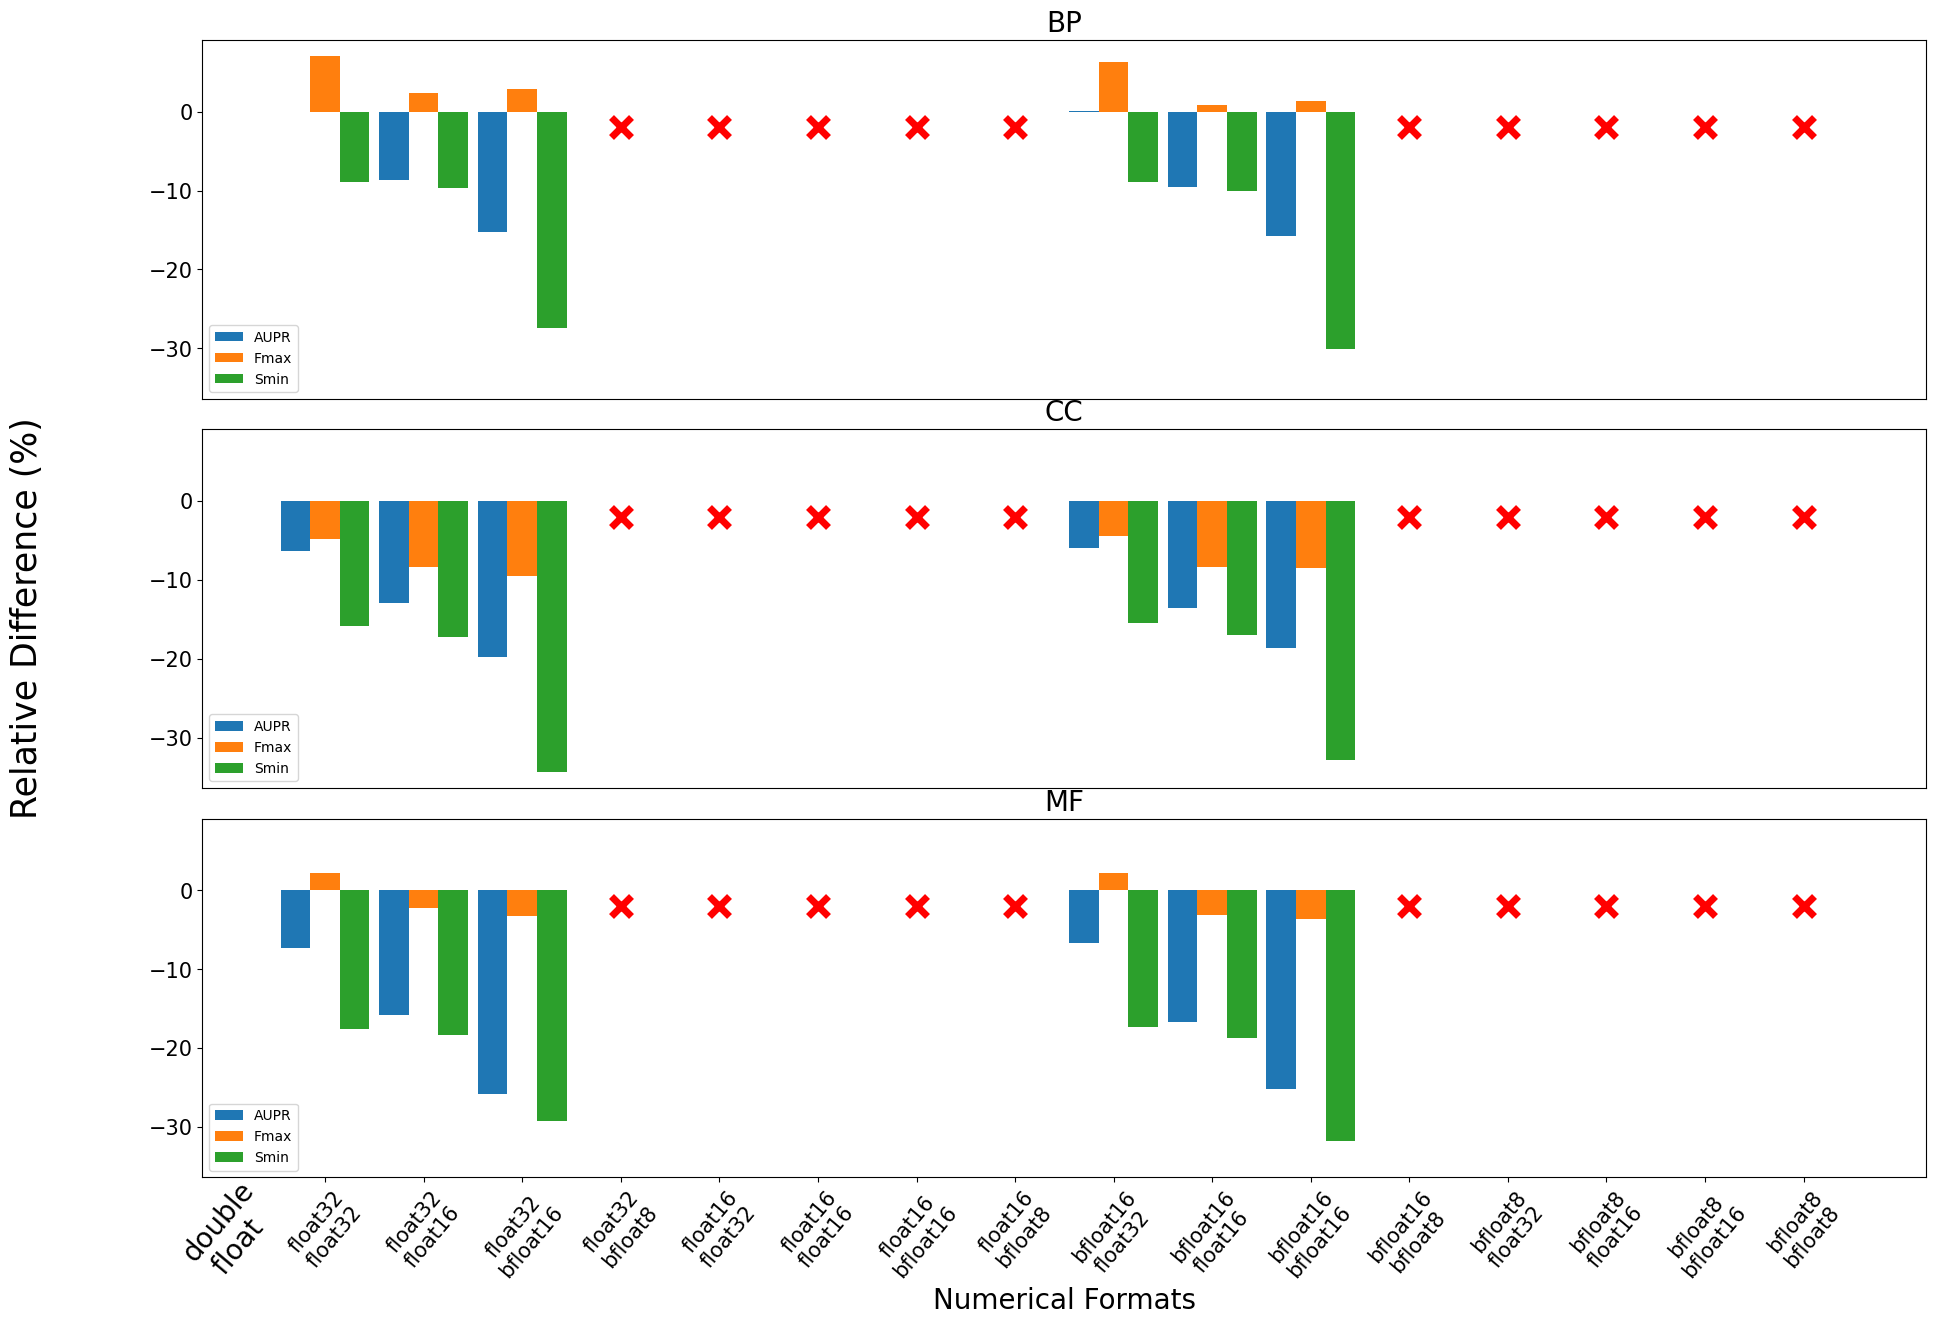

In [39]:
heatmap = {}
reduced_preds = ['23_23', '23_10', '23_7', '23_2.', '10_23', '10_10', '10_7', '10_2.', '7_23', '7_10', '7_7', '7_2.', '2_23', '2_10', '2_7', '2_2.']
temp = {'aupr':[], 'thresh':[], 'fmax':[], 'smin':[]}
x = np.arange(16)
bar_width = 0.3


fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(18, 12))
gs = fig.add_gridspec(3, hspace=0.0)

fig.tight_layout(pad=1.2)
fig.text(-0.08, 0.5, 'Relative Difference (%)', fontsize=25, va='center', rotation='vertical')

for num, category in enumerate(df_metric):

    heatmap[category] = {'smin': {'value': [], 'double': [], 'float': []},
                        'aupr': {'value': [], 'double': [], 'float': []},
                        'fmax': {'value': [], 'double': [], 'float': []}}

    
#     thresh = []
    smin = []
    fmax = []
    aupr = []
    for format_combo in reduced_preds: #df_metric[category]:
        
        for m in ['smin', 'fmax', 'aupr']:
            heatmap[category][m]['double'].append(int(format_combo.split('_')[0]))
            heatmap[category][m]['float'].append(int(format_combo.split('_')[1].split('.')[0]))

        
        if '10_' in format_combo or '_2.' in format_combo or '2_' in format_combo:
#             thresh.append(0)
            smin.append(0)
            fmax.append(0)
            aupr.append(0)
            
            heatmap[category]['smin']['value'].append(np.nan)
            heatmap[category]['fmax']['value'].append(np.nan)
            heatmap[category]['aupr']['value'].append(np.nan)

            continue
            
        s_metric = ((df_metric[category][format_combo]['Smin']['Original Result'] - df_metric[category][format_combo]['Smin']['VPREC Results']).item() / df_metric[category][format_combo]['Smin']['Original Result']).item()*100
        f_metric = (-(df_metric[category][format_combo]['Fmax']['Original Result'] - df_metric[category][format_combo]['Fmax']['VPREC Results']).item() / df_metric[category][format_combo]['Fmax']['Original Result']).item()*100
        a_metric = (-(df_metric[category][format_combo]['AUPR']['Original Result'] - df_metric[category][format_combo]['AUPR']['VPREC Results']).item() / df_metric[category][format_combo]['AUPR']['Original Result']).item()*100
        
        smin.append(s_metric)
        fmax.append(f_metric)
        aupr.append(a_metric)
        
        heatmap[category]['smin']['value'].append(s_metric)
        heatmap[category]['fmax']['value'].append(f_metric)
        heatmap[category]['aupr']['value'].append(a_metric)


    b1 = ax[num].bar(x, aupr, width=bar_width, label='AUPR')
    b2 = ax[num].bar(x + bar_width, fmax, width=bar_width, label='Fmax')
    b3 = ax[num].bar(x + 2*bar_width, smin, width=bar_width, label='Smin')
    ax[num].legend(prop={'size': 20})
    ax[num].set_xticks(x + bar_width), ax[num].legend()#, ax.set_title(category + ' Difference between Reduced Precision and IEEE', fontsize=15)
    ax[num].set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'float32\nbfloat8', 'float16\nfloat32', 'float16\nfloat16', 'float16\nbfloat16', 'float16\nbfloat8', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16', 'bfloat16\nbfloat8', 'bfloat8\nfloat32', 'bfloat8\nfloat16', 'bfloat8\nbfloat16', 'bfloat8\nbfloat8'], rotation=50, fontsize=35);
    ax[2].set_xlabel('Numerical Formats', fontsize=20)#, ax[num].set_ylabel('Relative Difference (%)', fontsize=15)

    ax[num].set_title(category.upper(), fontsize=20)
    ax[num].plot(np.arange(16)+0.3, np.ones(16)*-2, 'rx', markevery=[3,4,5,6,7,11,12,13,14,15], mew=5, markersize=15)

    temp['aupr'].append(aupr)
#     temp['thresh'].append(thresh)
    temp['fmax'].append(fmax)
    temp['smin'].append(smin)
    
       
for ax in fig.get_axes()[:-1]:
    ax.tick_params(bottom=False, labelbottom=False, labelsize=15)

for ax in fig.get_axes():
    ax.tick_params(labelsize=15)

ax.text(-1.2, -49.5, 'double\n float', rotation=50, fontsize=20);


# plt.savefig('reduced_combo_ob.png', bbox_inches ="tight")

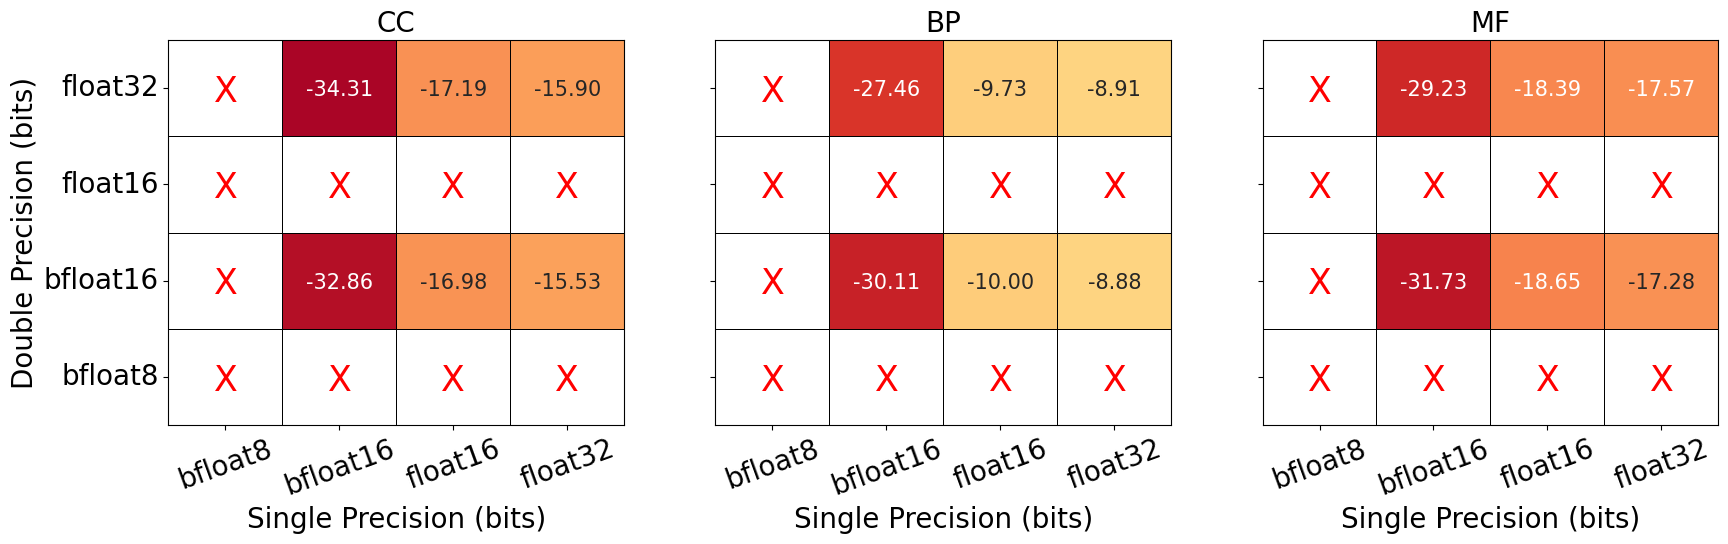

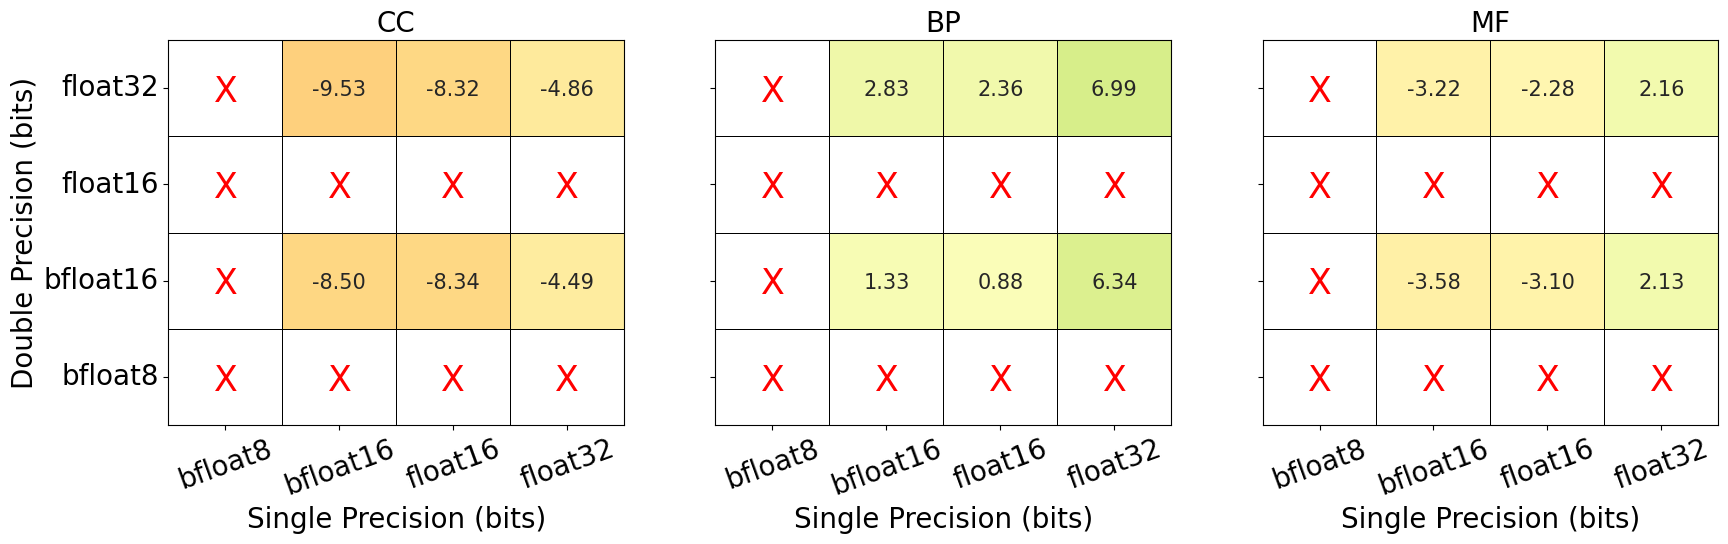

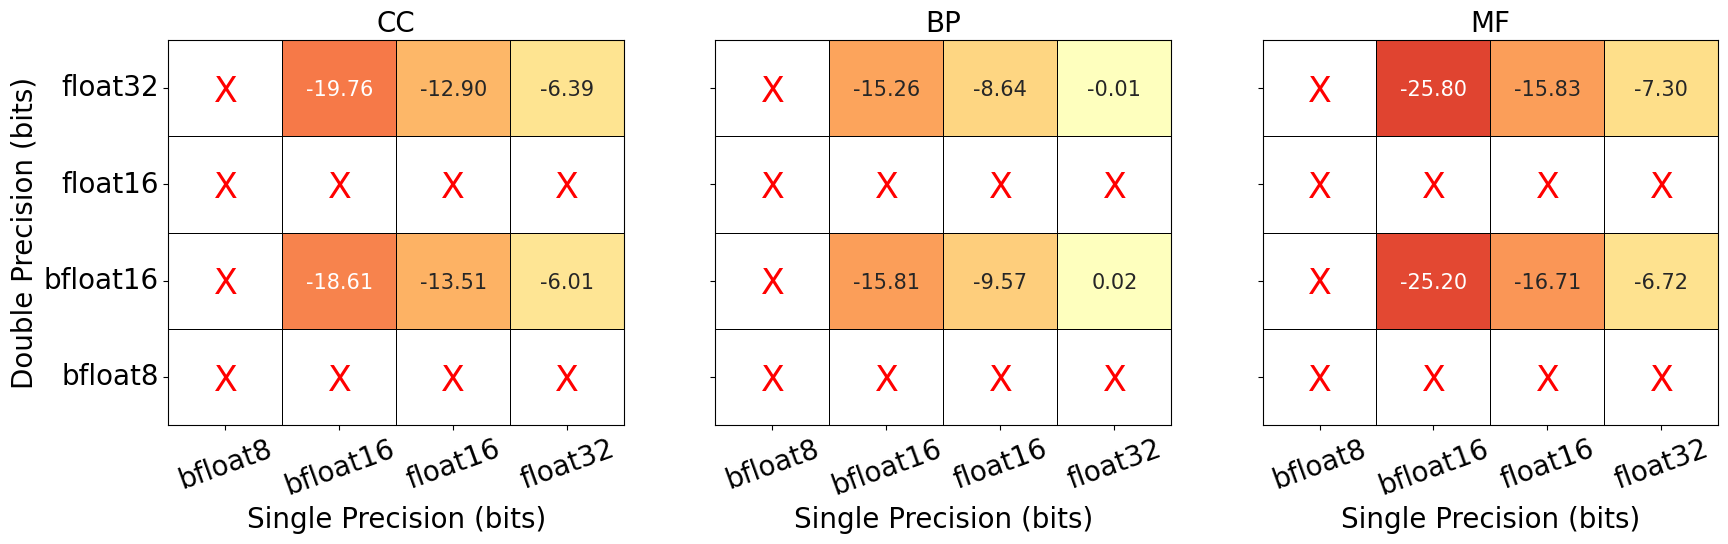

In [40]:
for m in ['smin', 'fmax', 'aupr']:
    fig, ax = plt.subplots(1,3,squeeze=False, figsize=(20,5), sharey=True)
    for num, ont in enumerate(['cc', 'bp', 'mf']):
        df = pd.DataFrame(heatmap[ont][m]).pivot(index='double', columns='float', values='value')

        annot_df = df.map(lambda f: f'{f:.2f}')
        sns.heatmap(
            np.where(df.isna(), 0, np.nan),
            ax=ax[0, num],
            cbar=False,
            annot=np.full_like(df, "X", dtype=object),
            fmt="",
            annot_kws={"size": 25, "va": "center_baseline", "color": "red"},
            cmap=ListedColormap(['none']),
            linewidth=.50)
        s = sns.heatmap(
            df,
            ax=ax[0, num],
            cbar=False,
            annot=annot_df,
            fmt="",
            annot_kws={"size": 15, "va": "center_baseline"},
            cmap=asym_cmap,
            linewidth=0.5,
            linecolor="black",
            vmin=-35,
            vmax=7,
            cbar_kws={"orientation": "horizontal"}
        )

        for _, spine in s.spines.items():
            spine.set_visible(True)

        s.set_xlabel('Single Precision (bits)', fontsize=20)
        if num == 0:
            s.set_ylabel('Double Precision (bits)', fontsize=20)
        else: s.set_ylabel("")
        s.set_title(f"{ont.upper()}", fontsize=20)
        s.set_yticklabels(['bfloat8','bfloat16','float16','float32'], size = 20, rotation=0)
        s.invert_yaxis()
        s.set_xticklabels(['bfloat8','bfloat16','float16','float32'], size = 20, rotation=20)

        plt.savefig(f'ob_reduced_{m}_heatmap.pdf', bbox_inches='tight', pad_inches=0.2)

#     break

plt.show()


### VPREC IB

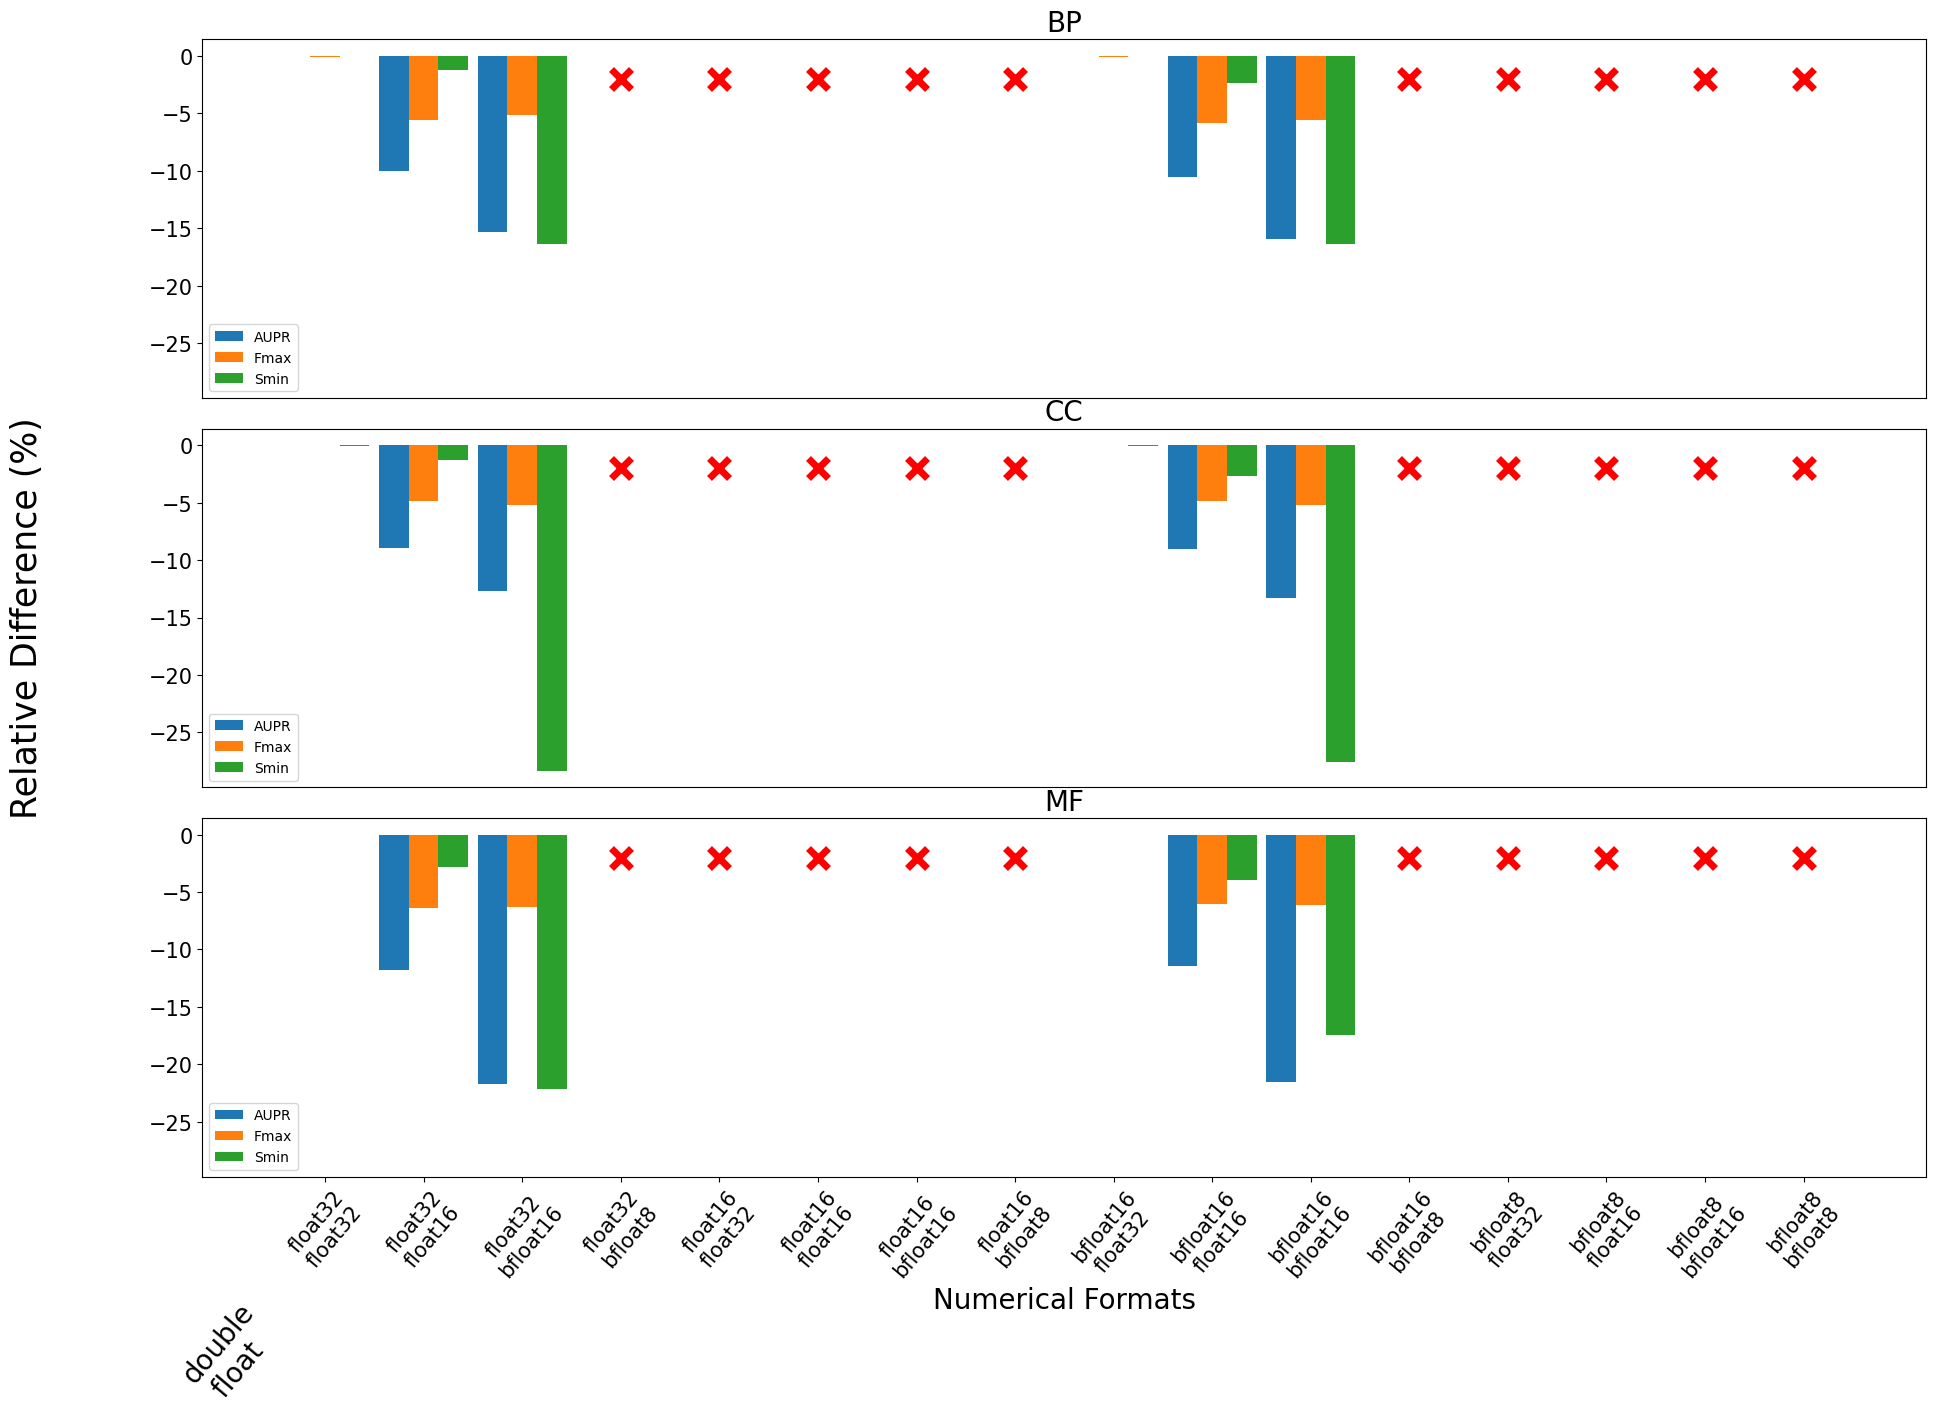

In [35]:
heatmap = {}
reduced_preds = ['23_23', '23_10', '23_7', '23_2.', '10_23', '10_10', '10_7', '10_2.', '7_23', '7_10', '7_7', '7_2.', '2_23', '2_10', '2_7', '2_2.']
temp = {'aupr':[], 'thresh':[], 'fmax':[], 'smin':[]}
x = np.arange(16)
bar_width = 0.3


fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(18, 12))
gs = fig.add_gridspec(3, hspace=0.0)

fig.tight_layout(pad=1.2)
fig.text(-0.08, 0.5, 'Relative Difference (%)', fontsize=25, va='center', rotation='vertical')

for num, category in enumerate(df_metric):

    heatmap[category] = {'smin': {'value': [], 'double': [], 'float': []},
                        'aupr': {'value': [], 'double': [], 'float': []},
                        'fmax': {'value': [], 'double': [], 'float': []}}

    
#     thresh = []
    smin = []
    fmax = []
    aupr = []
    for format_combo in reduced_preds: #df_metric[category]:
        
        for m in ['smin', 'fmax', 'aupr']:
            heatmap[category][m]['double'].append(int(format_combo.split('_')[0]))
            heatmap[category][m]['float'].append(int(format_combo.split('_')[1].split('.')[0]))

        
        if '10_' in format_combo or '_2.' in format_combo or '2_' in format_combo:
#             thresh.append(0)
            smin.append(0)
            fmax.append(0)
            aupr.append(0)
            
            heatmap[category]['smin']['value'].append(np.nan)
            heatmap[category]['fmax']['value'].append(np.nan)
            heatmap[category]['aupr']['value'].append(np.nan)

            continue
            
        s_metric = ((df_metric[category][format_combo]['Smin']['Original Result'] - df_metric[category][format_combo]['Smin']['VPREC Results']).item() / df_metric[category][format_combo]['Smin']['Original Result']).item()*100
        f_metric = (-(df_metric[category][format_combo]['Fmax']['Original Result'] - df_metric[category][format_combo]['Fmax']['VPREC Results']).item() / df_metric[category][format_combo]['Fmax']['Original Result']).item()*100
        a_metric = (-(df_metric[category][format_combo]['AUPR']['Original Result'] - df_metric[category][format_combo]['AUPR']['VPREC Results']).item() / df_metric[category][format_combo]['AUPR']['Original Result']).item()*100
        
        smin.append(s_metric)
        fmax.append(f_metric)
        aupr.append(a_metric)
        
        heatmap[category]['smin']['value'].append(s_metric)
        heatmap[category]['fmax']['value'].append(f_metric)
        heatmap[category]['aupr']['value'].append(a_metric)


    b1 = ax[num].bar(x, aupr, width=bar_width, label='AUPR')
    b2 = ax[num].bar(x + bar_width, fmax, width=bar_width, label='Fmax')
    b3 = ax[num].bar(x + 2*bar_width, smin, width=bar_width, label='Smin')
    ax[num].legend(prop={'size': 20})
    ax[num].set_xticks(x + bar_width), ax[num].legend()#, ax.set_title(category + ' Difference between Reduced Precision and IEEE', fontsize=15)
    ax[num].set_xticklabels(['float32\nfloat32', 'float32\nfloat16', 'float32\nbfloat16', 'float32\nbfloat8', 'float16\nfloat32', 'float16\nfloat16', 'float16\nbfloat16', 'float16\nbfloat8', 'bfloat16\nfloat32', 'bfloat16\nfloat16', 'bfloat16\nbfloat16', 'bfloat16\nbfloat8', 'bfloat8\nfloat32', 'bfloat8\nfloat16', 'bfloat8\nbfloat16', 'bfloat8\nbfloat8'], rotation=50, fontsize=35);
    ax[2].set_xlabel('Numerical Formats', fontsize=20)#, ax[num].set_ylabel('Relative Difference (%)', fontsize=15)

    ax[num].set_title(category.upper(), fontsize=20)
    ax[num].plot(np.arange(16)+0.3, np.ones(16)*-2, 'rx', markevery=[3,4,5,6,7,11,12,13,14,15], mew=5, markersize=15)

    temp['aupr'].append(aupr)
#     temp['thresh'].append(thresh)
    temp['fmax'].append(fmax)
    temp['smin'].append(smin)
    
       
for ax in fig.get_axes()[:-1]:
    ax.tick_params(bottom=False, labelbottom=False, labelsize=15)

for ax in fig.get_axes():
    ax.tick_params(labelsize=15)

ax.text(-1.2, -49.5, 'double\n float', rotation=50, fontsize=20);


# plt.savefig('reduced_combo_ib.png', bbox_inches ="tight")

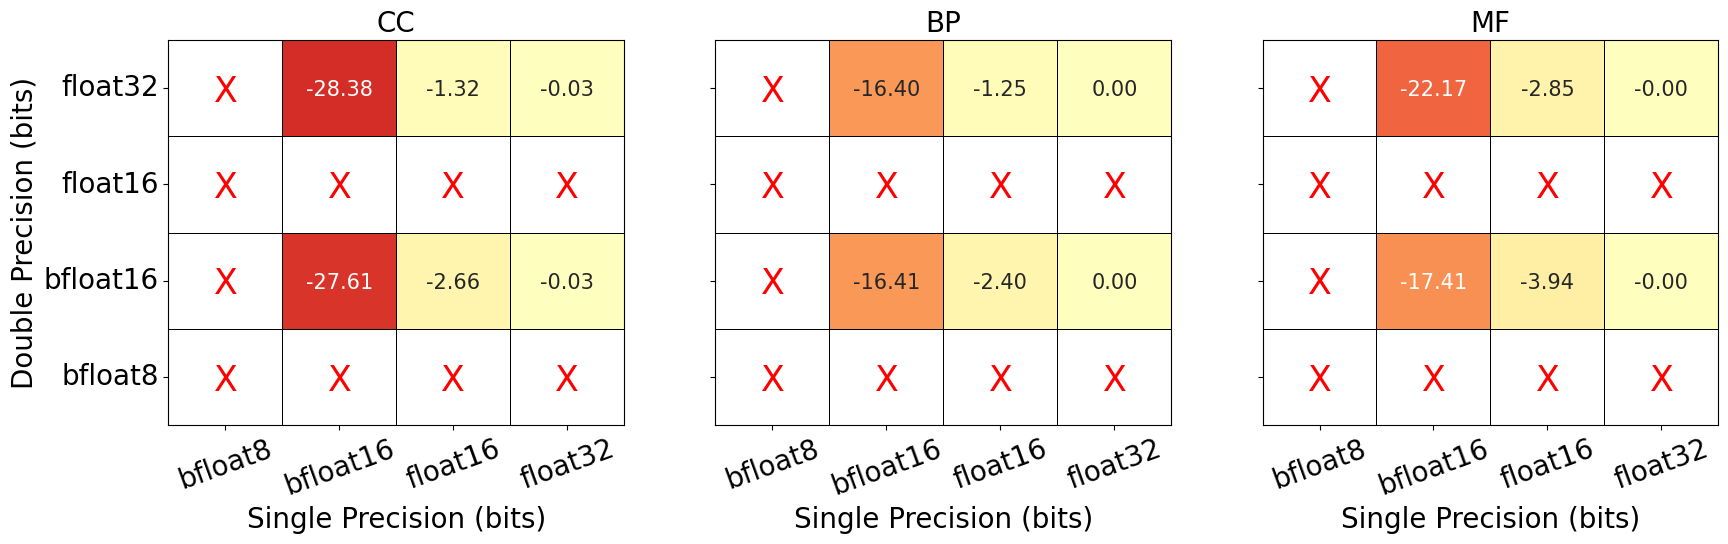

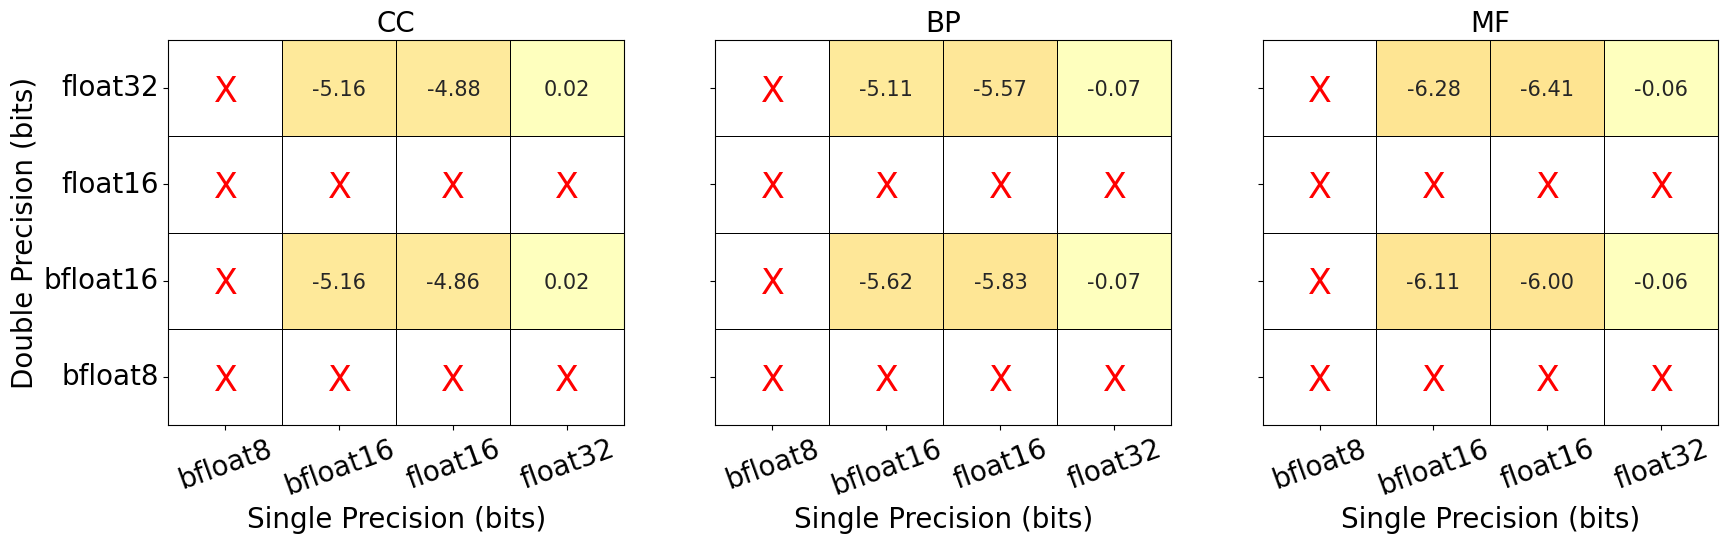

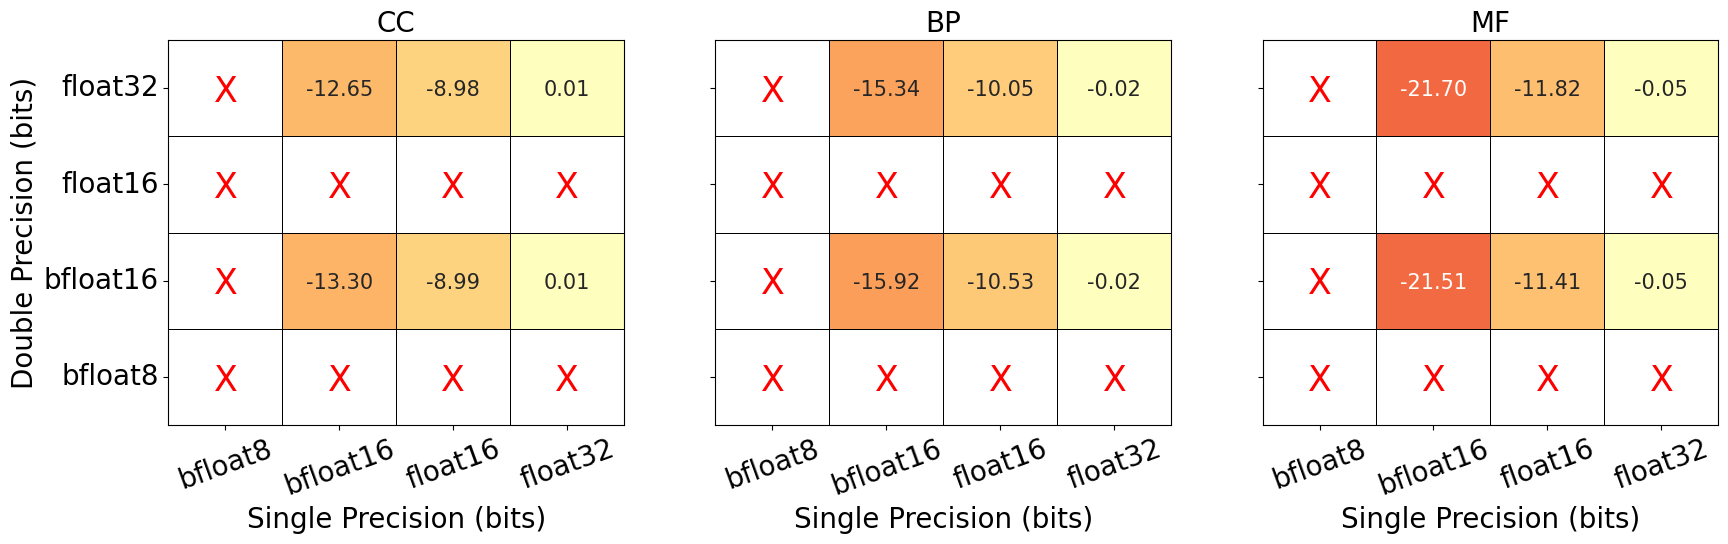

In [36]:
for m in ['smin', 'fmax', 'aupr']:
    fig, ax = plt.subplots(1,3,squeeze=False, figsize=(20,5), sharey=True)
    for num, ont in enumerate(['cc', 'bp', 'mf']):
        df = pd.DataFrame(heatmap[ont][m]).pivot(index='double', columns='float', values='value')

        annot_df = df.map(lambda f: f'{f:.2f}')
        sns.heatmap(
            np.where(df.isna(), 0, np.nan),
            ax=ax[0, num],
            cbar=False,
            annot=np.full_like(df, "X", dtype=object),
            fmt="",
            annot_kws={"size": 25, "va": "center_baseline", "color": "red"},
            cmap=ListedColormap(['none']),
            linewidth=.50)
        s = sns.heatmap(
            df,
            ax=ax[0, num],
            cbar=False,
            annot=annot_df,
            fmt="",
            annot_kws={"size": 15, "va": "center_baseline"},
            cmap=asym_cmap,
            linewidth=0.5,
            linecolor="black",
            vmin=-35,
            vmax=7,
            cbar_kws={"orientation": "horizontal"}
        )

        for _, spine in s.spines.items():
            spine.set_visible(True)

        s.set_xlabel('Single Precision (bits)', fontsize=20)
        if num == 0:
            s.set_ylabel('Double Precision (bits)', fontsize=20)
        else: s.set_ylabel("")
        s.set_title(f"{ont.upper()}", fontsize=20)
        s.set_yticklabels(['bfloat8','bfloat16','float16','float32'], size = 20, rotation=0)
        s.invert_yaxis()
        s.set_xticklabels(['bfloat8','bfloat16','float16','float32'], size = 20, rotation=20)

        # plt.savefig(f'Figures/ob_reduced_{m}_heatmap.pdf', bbox_inches='tight', pad_inches=0.2)

#     break

plt.show()
